# 当前问题：
1. 光行差问题，数据给出的ra,dec是csst观测得到的，毕竟还要拟合视差。但是模拟数据似乎没有考虑csst运动导致的光行差，拿source_id=0的第一个源举例，光行差量级应该在0.001到0.01deg，而ra，dec的波动仅为0.00001deg以下。如果引入光行差修正，拟合质量极差。因此这里忽略了光行差修正，但是这样csst速度数据就没用了。
2. 

# Note:
source_id = 0, 1 应为单星，source_id=2 应该为双星，可以用于初步测试

In [61]:
# 函数
import numpy as np
from functions import *
from models import *
import aux
from scipy.optimize import leastsq

# 读取数据
需要将.csv文件与脚本放在同一个文件夹

In [62]:
#读取本地 ast_epoch_data.csv
import pandas as pd
import numpy as np

df = pd.read_csv('ast_epoch_data.csv')

# 将每一列转化为一个numpy array
source_id = df['source_id'].to_numpy()
t_obs = df['t'].to_numpy()
csst_pos_obs = df[['bx','by','bz']].to_numpy()
csst_v_obs = df[['vx', 'vy', 'vz']].to_numpy()
ra_obs = df['ra'].to_numpy()
dec_obs = df['dec'].to_numpy()
ra_err_obs = df['ra_err'].to_numpy()   # mas 
dec_err_obs = df['dec_err'].to_numpy()  # mas 

# 拟合

## 单星模型拟合
先用单星模型拟合COM运动，作为后续轨道拟合的质心坐标以及速度的初值。
赤经和赤纬与初始值作差后再拟合

In [63]:
# 先提取一个源出来试试
random_source_id = np.random.choice(source_id)
print(random_source_id)
mask = (source_id == random_source_id)

t = t_obs[mask]
csst_pos = csst_pos_obs[mask]
csst_v = csst_v_obs[mask]
ra = ra_obs[mask]
dec = dec_obs[mask]
ra_err = ra_err_obs[mask]
dec_err = dec_err_obs[mask]

# 作差
d_ra = (ra - ra[0]) / np.cos(np.radians(dec)) * 3.6e6 # 除以cos dec以归一化xy方向尺度
d_dec = (dec - dec[0]) * 3.6e6 # mas

11010


[ 1.95416532e-01  1.25966646e-02  6.36412815e+01 -3.03520359e+01
  2.53216542e-01]
收敛信息: `ftol` termination condition is satisfied.
迭代次数: 19
最终残差平方和: 102.78733365729693


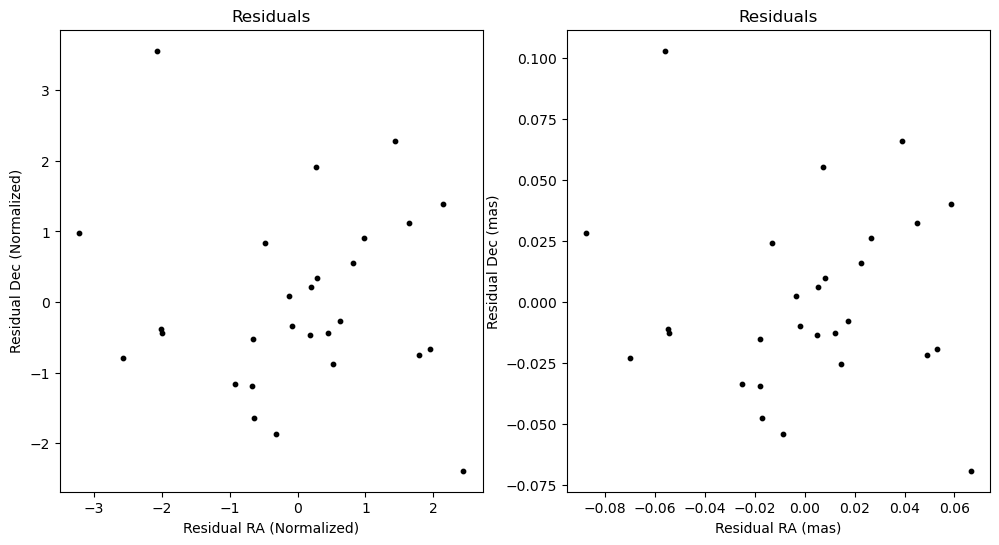

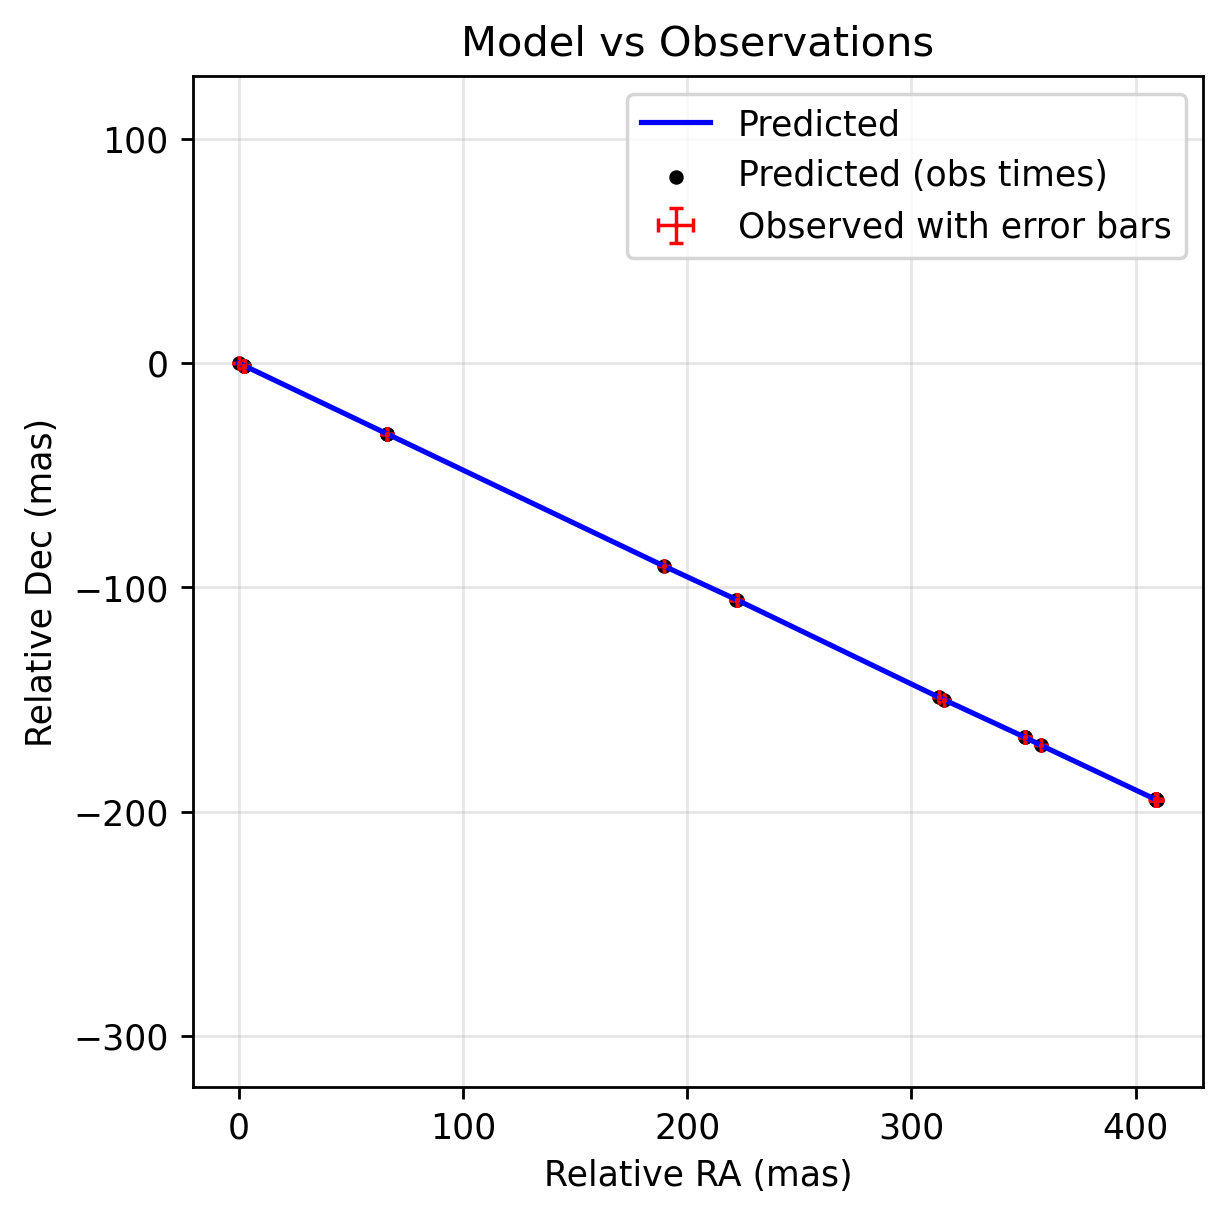

In [64]:
from scipy.optimize import least_squares

# 初始参数猜测
initial_five_params = [0, # d_ra guess (deg)
                  0, # d_dec guess (deg)
                  0, # pmra guess (mas/yr)
                  0, # pmdec guess (mas/yr)
                  100] # parallax guess (mas)

u = np.array([np.cos(np.radians(ra[0])) * np.cos(np.radians(dec[0])),
               np.sin(np.radians(ra[0])) * np.cos(np.radians(dec[0])),
               np.sin(np.radians(dec[0]))])  # 源的（初始）方向矢量



result_com = least_squares(
    cal_residual,
    initial_five_params,
    args=(t, d_ra, d_dec, ra_err, dec_err, csst_pos, csst_v, u, single_star_model),
    method='lm', 
    max_nfev=10000,
    jac='2-point'  # 计算雅可比矩阵的方法 （'2
)

five_params = result_com.x
print(result_com.x)
pcov = cal_cov_and_print(result_com)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_norm_residual(result_com.fun, ax=axes[0])
plot_residual(single_star_model, five_params, t, d_ra, d_dec, ra_err, dec_err, 
                        csst_pos, csst_v, u, ax=axes[1])

plot_model_and_obs(single_star_model, five_params, t, d_ra, d_dec, ra_err, dec_err, csst_pos, csst_v, u, num_points=None)

双星轨道拟合，使用单星拟合结果作为5参数初值。

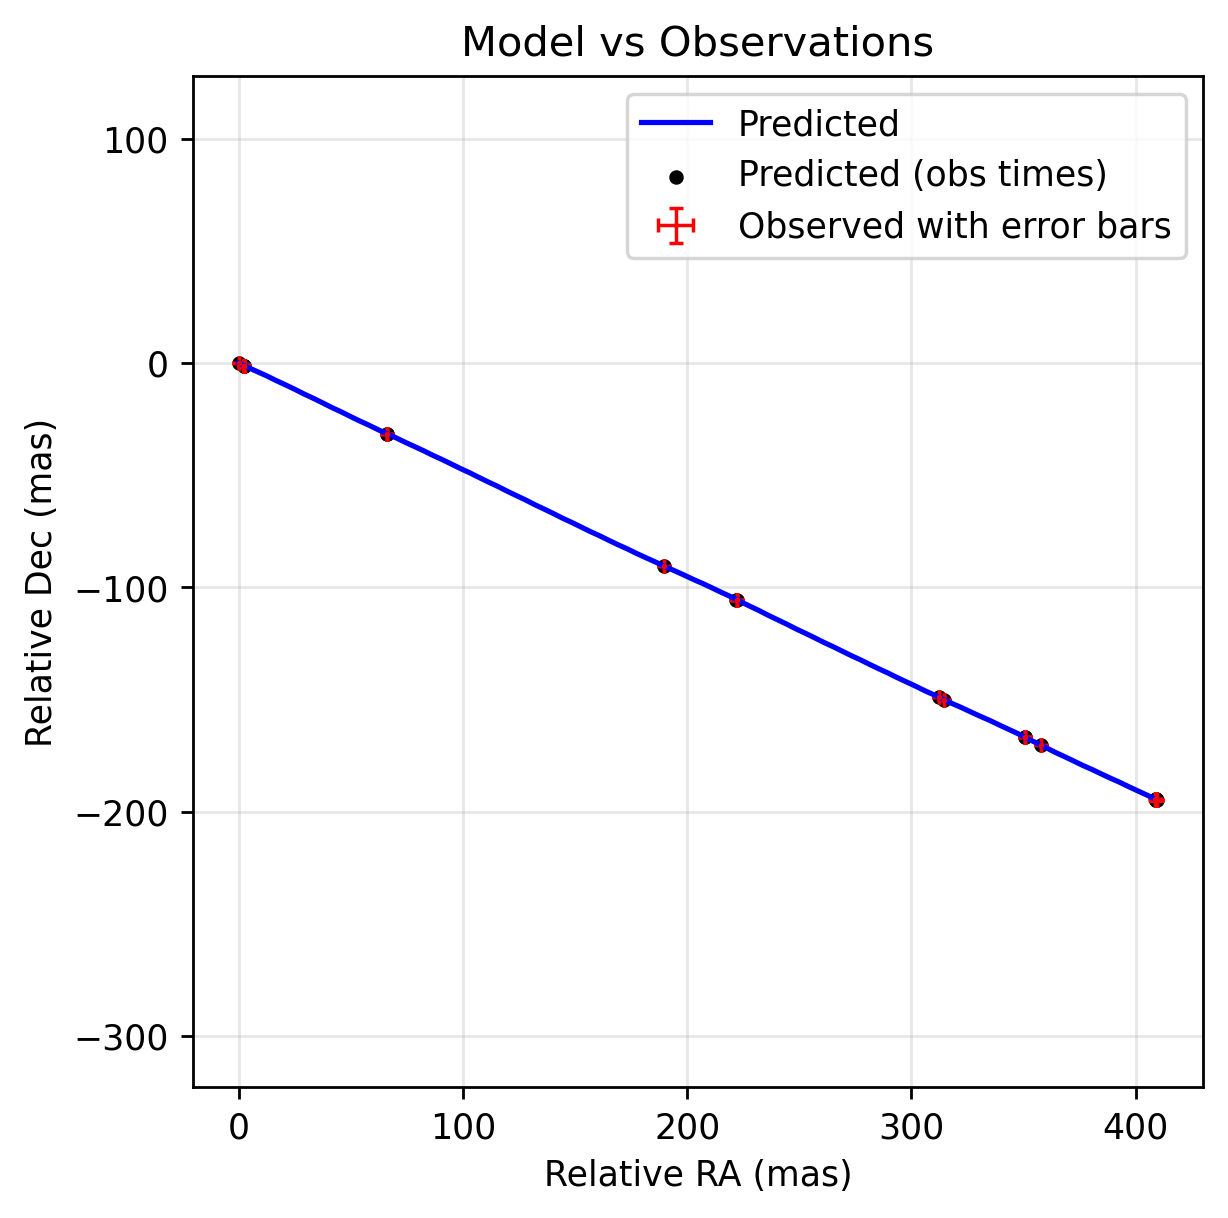

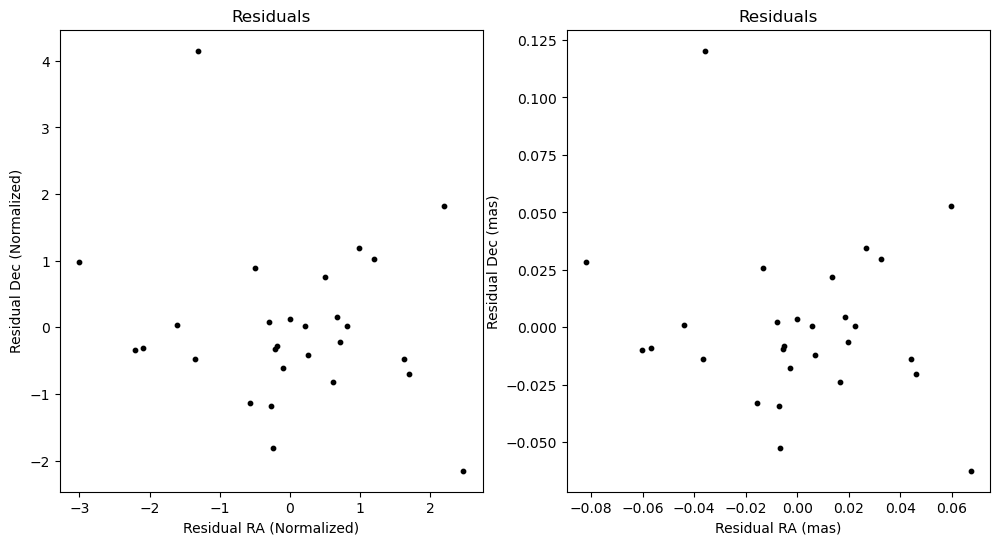

收敛信息: `xtol` termination condition is satisfied.
迭代次数: 53
最终残差平方和: 85.1133670419406
initial 5-p solution: ['0.20', '0.01', '63.64', '-30.35', '0.25']
ra_com: 0.21 +- 0.05
dec_com: 0.04 +- 0.06
pmra_com: 63.64 +- 0.01
pmdec_com: -30.35 +- 0.01
plx: 0.26 +- 0.02
period: 0.10 +- 0.00
ecc: 0.00 +- 1.44
M0: 0.00 +- 4788.67
A: 0.03 +- 80.48
B: 0.04 +- 81.19
F: 0.02 +- 146.36
G: -0.02 +- 190.90


In [65]:
from scipy.optimize import least_squares

MODEL = orbit_model_ti

args = (t, d_ra, d_dec, ra_err, dec_err, csst_pos, csst_v, u, MODEL)

METHOD = 'trf' # other: 'lm', 'trf', 'dogbox'

# 执行加权最小二乘拟合
result = least_squares(
    cal_residual,           # 残差函数
    aux.initial_params(MODEL),     # 初始参数
    args=args,          # 其他参数
    bounds=aux.get_bounds(MODEL), # 参数边界 (lm 方法不可以)
    method=METHOD,     # 拟合方法
    jac='2-point',           # 计算雅可比矩阵的方法 （'2-point / 3-point / cs')
    max_nfev=10000         # 最大函数迭代次数
)

# 提取拟合参数
params = result.x
param_names = aux.get_param_names(MODEL)


try: 
    plot_model_and_obs(MODEL, params, t, d_ra, d_dec, ra_err, dec_err, csst_pos, csst_v, u, num_points=100)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plot_norm_residual(result.fun, ax=axes[0])
    plot_residual(MODEL, params, t, d_ra, d_dec, ra_err, dec_err, 
                            csst_pos, csst_v, u, ax=axes[1])
    
    pcov, perr = cal_cov_and_print(result)
    print(f'initial 5-p solution: {[f"{x:.2f}" for x in five_params]}')
    for param, param_name, param_err in zip(params, param_names, perr):
        print(f'{param_name}: {param:.2f} +- {param_err:.2f}')
        
except Exception as e:
    print(f"Error occurred: {e}")

# 参数相关性分析

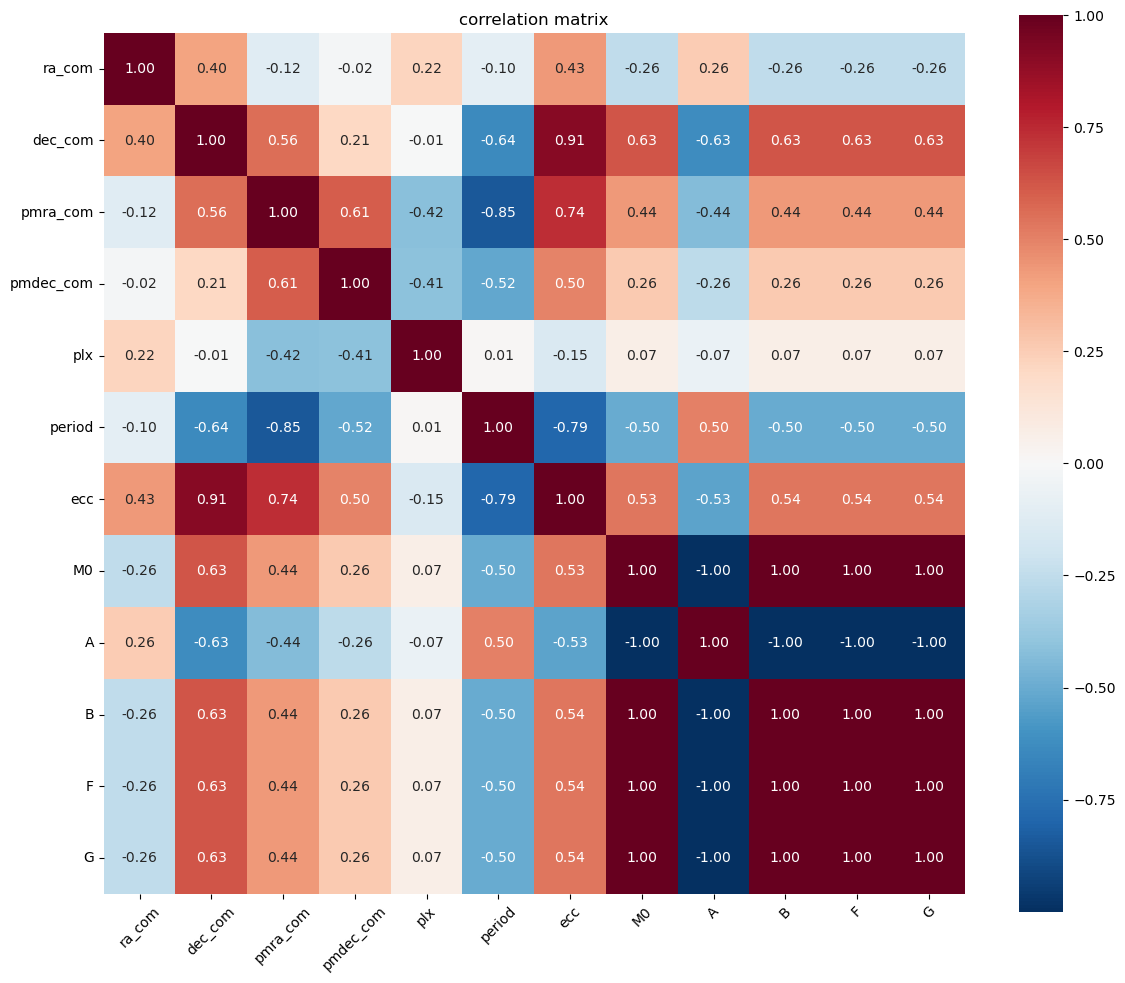

In [66]:
from matplotlib import pyplot as plt
import seaborn as sns

correlation_analysis(pcov, param_names=param_names)